In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Introduction
* The goal is to predict the target value in the dataset which is dependent on 
   1. Anonymous feature values, the values look like they are processed too.
   2. Different thousands of investments, probably with different investment strategies
   3. The investments may have been taken in different time
   4. It is also observed that the timeid are not continous

# Goal

* To create a model to predict the target variable from the given features.

# Test Dataset

In test set we expect to see roughly one million instances. (Info shared by hosts)
We also know test observations will be taken after the training observation period.
This is code competition so our submissions will be made from inside of a Kaggle notebook.
These submissions will be evaluated using time-series API, hosts kindly reminded us about the memory constraints of this approach.


# Evaluation Metric

* **Pearson Coefficient**-  is a measure of linear correlation between two sets of data. It is the ratio between the covariance of two variables and the product of their standard deviations; thus it is essentially a normalized measurement of the covariance, such that the result always has a value between −1 and 1. As with covariance itself, the measure can only reflect a linear correlation of variables, and ignores many other types of relationship or correlation. As a simple example, one would expect the age and height of a sample of teenagers from a high school to have a Pearson correlation coefficient significantly greater than 0, but less than 1 (as 1 would represent an unrealistically perfect correlation).

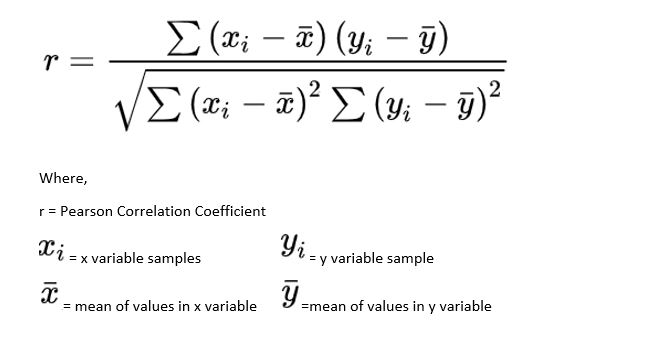

Big shoutout for **ERTUGRUL DEMIR** for such a good notebook on EDA!

https://www.kaggle.com/datafan07/ubiquant-market-prediction-what-do-we-have-here#Some-'Odd'-Feature-Distributions 

# Additional Libraries imported and parameters

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import norm,skew,kurtosis

import gc
plt.style.use('ggplot')

cust_color = [
    '#EDC7B7',
    '#EEE2DC',
    '#BAB2B5',
    '#123C69',
    '#AC3B61'
]

plt.rcParams['figure.figsize'] = (18,14)
plt.rcParams['figure.dpi'] = 300
plt.rcParams["axes.grid"] = True
plt.rcParams["grid.color"] = cust_color[0]
plt.rcParams["grid.alpha"] = 0.5
plt.rcParams["grid.linestyle"] = '--'
plt.rcParams["font.family"] = "monospace"

plt.rcParams['axes.edgecolor'] = 'black'
plt.rcParams['figure.frameon'] = False
plt.rcParams['axes.spines.left'] = True
plt.rcParams['axes.spines.bottom'] = True
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.linewidth'] = 1.0

import warnings
warnings.filterwarnings("ignore")

In [ ]:
df_train = pd.read_parquet('/kaggle/input/train-low-mem-parquet/train_low_mem.parquet')
df_test = pd.read_csv('/kaggle/input/ubiquant-market-prediction/example_test.csv')
df_submission = pd.read_csv('/kaggle/input/ubiquant-market-prediction/example_sample_submission.csv')

# Function to reduce memory usage of dataset

In [ ]:
def reduce_mem_usage(df):
  
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
     
    return df

df_train = reduce_mem_usage(df_train)

# Exploratory Data Analysis

**First Look**

Let's look at our train data first**

In [ ]:
df_train.head()

**Number of records**

The train dataset has 3141410 rows and 304 columns

In [ ]:
df_train.shape

**Checking for missing values**

**df_train.isnull().sum()** - gives column wise null values and **df_train.isnull().sum().sum()** gives number of null values in the whole dataset

In [ ]:
df_train.isnull().sum().sum()

In the dataset we have a column called as **investment_id** which denotes the id for an investment.

Let us see the number of unique investment ids in the dataset

In [ ]:
df_train.investment_id.nunique()

Let us see the count of highest investment_id to least in the dataset

* It is evident that the investment_id '2572.0' has highest number of rows i.e 3576, while the id '1415.0' has only 2 occurences 

In [ ]:
df_train['investment_id'].value_counts()

In [ ]:

fig,ax = plt.subplots(figsize = (12,9))
sns.countplot(x='investment_id', data=df_train, color = cust_color[-1])
plt.title('Count of Investment ids from least to highest occurence')
plt.show()

In the dataset we have a column called as **time_id** which denotes the ID code for the time the data was gathered. 

Let us see the number of unique time ids in the dataset

In [ ]:
df_train['time_id'].nunique()

Let us see the count of highest investment_id to least in the dataset

* It is evident that the time_id '1214.0' has highest number of occurences i.e 3576, while the id '492.0' has only 512 occurences 

In [ ]:
df_train['time_id'].value_counts()

In [ ]:
fig,ax = plt.subplots(figsize = (12,9))

sns.countplot(x='time_id', data= df_train, color= cust_color[-1])
plt.title('Time_id occurences')
plt.show()

In this cell I have taken the mean of target variable grouped by investment_id

**Conclusions**

* The data is skewed to the left 
* Most of the investments have mean returns in the range of -0.2 to 0.2

In [ ]:
returns_by_investmentid = df_train.groupby('investment_id')['target'].mean()

fig,ax = plt.subplots(figsize = (12,9))
sns.histplot(returns_by_investmentid, color = cust_color[3], kde = True)
plt.title('mean of target variable grouped by investmentid')
plt.show()

Investment ID whose mean returns are less than -0.2,We can remove the below **16** Investment Id considering them as **"Outliers"** and remove from the original dataset

In [ ]:
df_mean_less = df_train.groupby('investment_id')['target'].mean() < -0.2 
mean_list = df_mean_less[df_mean_less == True].index.tolist()
mean_list

Investment ID whose mean returns are greater than 0.2,We can remove the below **3** Investment Id considering them as **"Outliers"** and remove from the original dataset

In [ ]:
df_mean_more = df_train.groupby('investment_id')['target'].mean() > 0.2 
df_mean_more[df_mean_more == True].index.tolist()


Lets see combine the list and select ony the rows excluding the **mean_list**

In [ ]:
mean_list.extend(df_mean_more[df_mean_more == True].index.tolist())
mean_list

It can be seen that we have successfully removed **1745** rows which contain the above investment_id and classified them as **outliers**

In [ ]:
df_train_selected = df_train[~df_train['investment_id'].isin(mean_list)]
df_train_selected.shape, df_train.shape

We will also look at the number of time ids per investment_id

In [ ]:
time_count = df_train.groupby('time_id')['investment_id'].count()
fig,ax = plt.subplots(figsize=(12,9))
sns.histplot(time_count, color= cust_color[3], kde = True)
plt.title('Investments per time_id')
plt.show()

* It is evident from the above figure that investment ids from 2000 to 2500 have highest number of timestamps
* Investment ids from 0 to 2000 have very less timestamps than from later half

# Random sampling

In [ ]:
df_sample = df_train_selected.sample(frac= 0.05, random_state=42)
df_sample.shape

* We can see that all the investment ids and time ids are included in the random sample data

In [ ]:
df_sample.investment_id.nunique(), df_sample.time_id.nunique()

* Box plot for target column

In [ ]:
fig,ax3 = plt.subplots(figsize=(12,9))
sns.boxplot(y= 'target', data=df_train_selected, ax=ax3, color=cust_color[-1])
plt.title('Box plot for target variable')
plt.show()

The long tails in the box plot indicates some outliers 
* The returns of investments are mostly centered around 0
* We can also standardize our data using sklearn libraries

# Feature Distributions

**Standard Deviation**

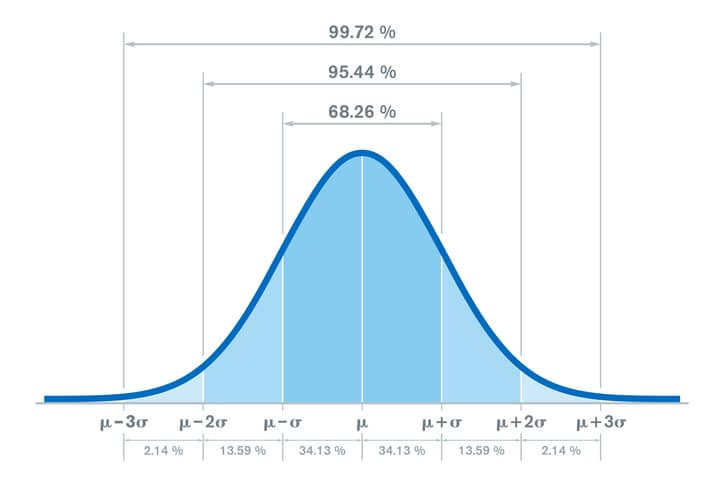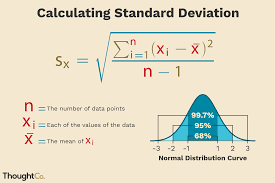

In [ ]:
std_features = df_sample.iloc[:,4:].apply(lambda x: np.std(x)).sort_values(ascending = False)
features_deviated = df_sample[std_features.iloc[:20].index.tolist()]
std_features[:20]

In [ ]:
#Function to display distributions taken from https://www.kaggle.com/datafan07/ubiquant-market-prediction-what-do-we-have-here#Some-'Odd'-Feature-Distributions

def feat_dist(df, cols, rows=3, columns=3, title=None, figsize=(30, 25)):
    
    '''A function for displaying skew feat distribution'''
    
    fig, axes = plt.subplots(rows, columns, figsize=figsize, constrained_layout=True)
    axes = axes.flatten()

    for i, j in zip(cols, axes):
        sns.distplot(
                    df[i],
                    ax=j,
                    fit=norm,
                    hist=False,
                    color=cust_color[-1],
                    kde_kws={'linewidth':3}
        )   
        
        (mu, sigma) = norm.fit(df[i])
        j.set_title('Dist of {0} Norm Fit: $\mu=${1:.2g}, $\sigma=${2:.2f}'.format(i, mu, sigma), weight='bold')
        j.legend(labels=[f'{i}', 'Normal Dist'])
        fig.suptitle(f'{title}', fontsize=24, weight='bold')

In [ ]:
feat_dist(df_sample, features_deviated.columns.tolist(), rows=5, columns=4, title='Distribution of High Std Features', figsize=(30, 16))

**Charecterisitics of a normal distribution**

* A normal distribution is the proper term for a probability bell curve.
* In a normal distribution the mean is zero and the standard deviation is 1. It has zero skew and a kurtosis of 3.
* Normal distributions are symmetrical, but not all symmetrical distributions are normal.

Considering the **top 20 columns** with highest standard deviations from the above it is evident that only columns **f_170,f_124,f_200 and f_204** are not close to their normal distributions hence we might definetly want to normalized thes columns

**Skewness Formula and sample distributions of left and right skews**

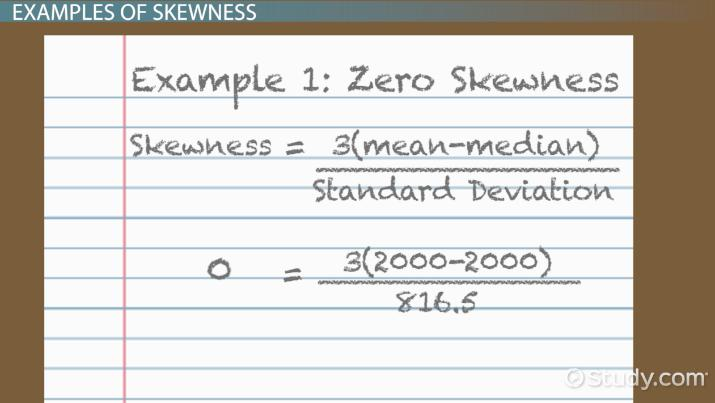
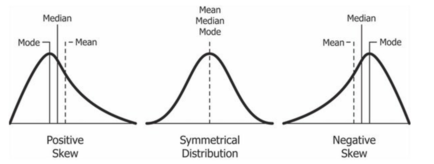

In [ ]:
with pd.option_context('mode.use_inf_as_na', True):
    features_skew = np.abs(df_sample.iloc[:,4:].apply(lambda x: np.abs(skew(x))).sort_values(
        ascending=False)).dropna()
skewed = df_sample[features_skew.iloc[:40].index.tolist()]
features_skew

In [ ]:
feat_dist(df_sample, skewed.columns.tolist(), rows=5, columns=4, title='Distribution of High Skewed Features', figsize=(30, 16))

We can see that most of the data is skewed either positively or negatively.

**How to interpret the graphs**
* Check which side the distributions have the maximum tail
* If the tail is longer towards left side then it is negatively skewed
* If the tail is longer towards the right side then it is positively skewed
* If the tails are equal we can do the kurtosis test to see the kurtosis value
* If ** kurtosis > 3 it is leptokurtic ** and if kurtosis<3 it is platykurtic and if the kurtosis ~3 then its is normal or (mesokurtic)

**Kurtosis**

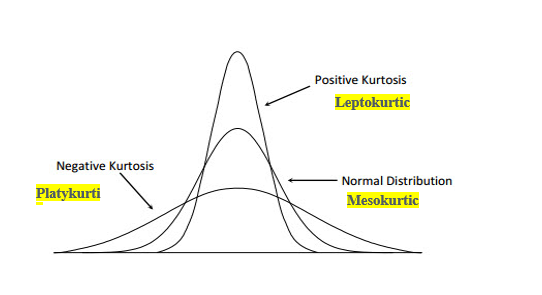

In [ ]:
with pd.option_context('mode.use_inf_as_na', True):
    features_kurt = np.abs(df_sample.iloc[:,4:].apply(lambda x: np.abs(kurtosis(x))).sort_values(
        ascending=False)).dropna()
kurt_f = df_sample[features_kurt.iloc[:20].index.tolist()]
features_kurt

In [ ]:
feat_dist(df_sample, kurt_f.columns.tolist(), rows=5, columns=4, title='Distribution of High kurtosis Features', figsize=(30, 16))

# Feature correlations with target variable

In [ ]:
top_20_corr_features = df_sample.corr()[['target']].sort_values( by='target', ascending = False).head(20)
top_20_neg_features = df_sample.corr()[['target']].sort_values(by='target').head(20)

fig,ax = plt.subplots(1,2)
heatmap = sns.heatmap(top_20_corr_features, vmin=-1, vmax= 1, annot= True, cmap = 'BrBG', ax = ax[0])
heatmap.set_title('Top 20 Postive Features Correlating with Sales Price', fontdict= {'fontsize':8}, pad = 16)
heatmap_negative = sns.heatmap(top_20_neg_features, vmin=-1, vmax = 1, annot = True, cmap = 'BrBG', ax = ax[1])
heatmap_negative.set_title('Top 20 Negative Features Correlating with Sales Price', fontdict = {'fontsize': 8}, pad = 16)

The above figures show the top 20 most positve and negatively correlated features from the 300 features in the dataset.

Let's use **SHAP** with some basic models to identify the most important attributes that effect the target variable. I am also going to change the **df_sample** by using different random states to get the clear pictures of the variables effecting target

* I am going to use very basic regression models to some advanced using pipelines

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

df_sample_1 = df_train.sample(frac = 0.01 , random_state = 1)
df_sample_2 = df_train.sample(frac = 0.01 , random_state = 2)
df_sample_3 = df_train.sample(frac = 0.01 , random_state = 3)

X_sample_1 = df_sample_1.loc[:,df_sample_1.columns != 'target']
y_sample_1 = df_sample_1['target']

X_train_sample_1, X_test_sample_1, y_train_sample_1, y_test_sample_1 = train_test_split(X_sample_1, y_sample_1, test_size = 0.2, random_state = 42)

X_sample_2 = df_sample_2.loc[:,df_sample_2.columns != 'target']
y_sample_2 = df_sample_2['target']

X_train_sample_2, X_test_sample_2, y_train_sample_2, y_test_sample_2 = train_test_split(X_sample_2, y_sample_2, test_size = 0.2, random_state = 42)

#X_sample_3 = df_sample_3.loc[:, df_sample_3.columns != 'target']
#y_sample_3 = df_sample_3['target']

lr_model = LinearRegression()
lr_model.fit(X_train_sample_1, y_train_sample_1)

#forest_model = RandomForestRegressor()
#forest_model.fit(X_sample_3, y_sample_3)

In [ ]:
lasso_model = Lasso()
lasso_model.fit(X_train_sample_2, y_train_sample_2)

In [ ]:
'''import shap
explainer = shap.LinearExplainer(lr_model, X_train_sample_1)
lr_shap_values = explainer.shap_values(X_test_sample_1)
X_test_array = X_test_sample_1.toarray() # we need to pass a dense version for the plotting functions
shap.summary_plot(lr_shap_values, X_test_array, plot_type = 'bar')'''

**WORK IN PROGRESS**

I am still going to add new features everyday in this notebook

Please comeback and check!!